# Grid search example

This is a grid search example, modified the default Bollinger bands example.

- Processes large dataset
- Run a grid search for historical ETH-USD data using Uniswap v2 price feed 
- Runs over a large grid search matrix
- Use multiprocessing to greatly scale the speed of grid search
    - This comes with added complexity, as we need to move part of the strategy to a Python module

For more details, see README.

### Github notebook rendering issues

**If you are viewing this file on Github**: The current Github online notebook viewer cannot render the interactive Plotly charts used in this notebook.
To view the charts, you need to download run the notebook locally.

## Multiprocessing set up

Because functions defined in Jupyter Notebook cells cannot be used in Python multiprocessing, we define our strategy parameters and functions in a Python module.
Then we import them here.

See [uniswap_grid_search.py](./tradingview_defi_strategy/uniswap_grid_search.py)

In [45]:
from tradingview_defi_strategy.uniswap_grid_search import grid_search_worker
from tradingview_defi_strategy.uniswap_grid_search import START_AT
from tradingview_defi_strategy.uniswap_grid_search import END_AT
from tradingview_defi_strategy.uniswap_grid_search import CANDLE_TIME_BUCKET
from tradingview_defi_strategy.uniswap_grid_search import TRADING_PAIR
from tradingview_defi_strategy.uniswap_grid_search import STOP_LOSS_TIME_BUCKET
from tradingview_defi_strategy.uniswap_grid_search import RSI_THRESHOLD
from tradingview_defi_strategy.uniswap_grid_search import STDDEV
from tradingview_defi_strategy.uniswap_grid_search import MOVING_AVERAGE_LENGTH

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [46]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    
    # Fetch backtesting datasets from the server 
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,        
        universe_options=universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [47]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Load data

This will pull JSONL data feed for the trading pair from Trading Strategy oracle node.

In [48]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

We loaded 25,890 candles.


## Prepare grid search

We prepare the grid search

- By definiting the strategy parameter search space

- Setting up the file system folder where the strategy run results are stored. The framework caches
  the results on disk, so that if the grid search is aborted, it can later resume and long operation results are not lost.

- If the grid search results already exist, the backtesting phase is skipped altogether and notebook directly jumps to analysis

- To make the analysis easier to read, you should choose the parameter with the most options, or most dominating, to be the first one

**Note**: If you change the strategy logic, or fixed parameters, you need to clear the cache folder with `clear_cached_results` setting:

```python
combinations = prepare_grid_combinations(parameters, storage_folder, clear_cached_results=True)
```

Otherwise the grid searcher will use the existing stored results and does not rerun your tests with the changed code.

In [49]:
from pathlib import Path

from tradeexecutor.backtest.grid_search import prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = Path("/tmp/{STRATEGY_NAME}")

parameters = {
    "rsi_threshold": RSI_THRESHOLD,
    "stddev": STDDEV,    
    "moving_average_length": MOVING_AVERAGE_LENGTH,
}
combinations = prepare_grid_combinations(parameters, storage_folder)
print(f"We prepared {len(combinations)} grid search combinations")

We prepared 100 grid search combinations


## Run grid search

Run backtest using giving trading universe and grid search worker function.

- Currently this runs in a threaded mode, which is memory optimised but not throughput optimised, for Python
- Increasing `max_workers` may not yield to speed gains

**Note**: The grid search will consume all of your CPU.
Even if you interrupt the kernel or close the notebook, multiprocess grid search does not abort in Visual Studio Code. You need to close your Visual Studio Editor fully.

In [50]:
from tradeexecutor.backtest.grid_search import perform_grid_search

grid_search_results = perform_grid_search(
    grid_search_worker,
    universe,
    combinations,  
    max_workers=8,  # Allocate 8 CPUs from the computer for the search
    multiprocess=True,
)


Grid searching using 8 processes: rsi_threshold, stddev, moving_average_length:   0%|          | 0/100 [00:00<…

## Analysing the grid search results

We examine the different grid search data.


In [51]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()

# Print extension of our backtest
print(f"Grid search combinations available: {len(grid_search_results)}")

Grid search combinations available: 100


### Grid combination table

Show the result of all combinations in a single table.


In [52]:
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table
table = analyse_grid_search_result(grid_search_results)

visualise_table(table)

## Two dimensional heatmaps

- Heatmap allows see how one strategy performance metrics varies over the search space
- The example has three parameter search space
- We compare two of these parameters and lock up one parameter to a fixed value

In [53]:
from tradeexecutor.analysis.grid_search import visualise_heatmap_2d

# Remove one extra axis by focusing only rsi_threshold=65
heatmap_data = table.xs(65, level="rsi_threshold")

# Draw heatmaps for two different metrics
fig = visualise_heatmap_2d(heatmap_data, "stddev", "moving_average_length", "Annualised profit")
display(fig)

In [54]:
# Draw another heatmap
fig = visualise_heatmap_2d(heatmap_data, "stddev", "moving_average_length", "Max drawdown")
display(fig)

In [55]:
# Draw another heatmap
fig = visualise_heatmap_2d(heatmap_data, "stddev", "moving_average_length", "Sortino")
display(fig)

## Examine the performance of the best combination

Show example statistics for one grid searched combination.

- In this example, we pick the strategy parameters optimised for annual return

In [56]:
from tradeexecutor.backtest.grid_search import pick_best_grid_search_result

best_return_result = pick_best_grid_search_result(
    grid_search_results,
    key=lambda result: result.summary.annualised_return_percent,
    highest=True,
)

state = best_return_result.state

print(f"The best annual return % was by {best_return_result.combination.get_label()}")

The best annual return % was by #27, rsi_threshold=65, stddev=2.5, moving_average_length=30


### Equity curve

Plot the equity curve of the examined strategy parameter combination.

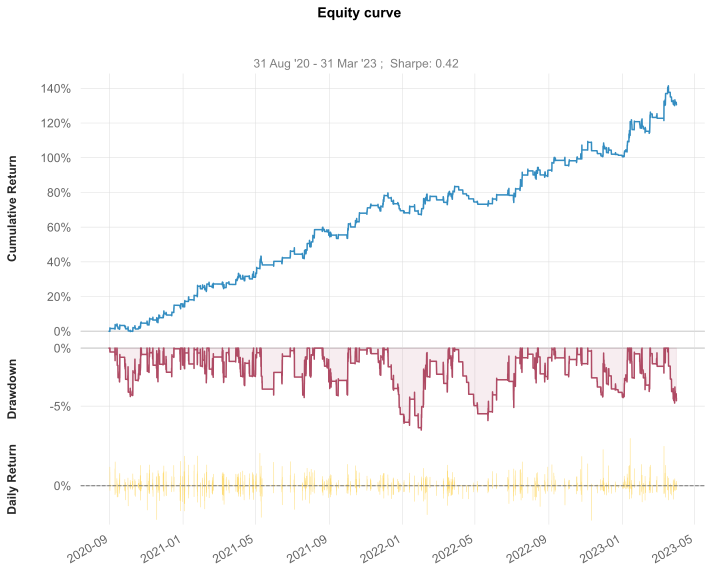

In [57]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Performance metrics

In [58]:
import pandas as pd

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

,Strategy
Start Period,2020-09-01
End Period,2023-03-31
Risk-Free Rate,0.0%
Time in Market,15.0%
Cumulative Return,130.9%
CAGR﹪,38.35%
Sharpe,0.5
Prob. Sharpe Ratio,100.0%
Smart Sharpe,0.5
Sortino,0.8


### Trading performance

In [59]:
summary = best_return_result.summary

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

,0
Trading period length,941 days
Return %,130.90%
Annualised return %,50.76%
Cash at start,"$5,000.00"
Value at end,"$11,544.86"
Trade volume,"$1,692,423.26"
Position win percent,51.69%
Total positions,207
Won positions,107
Lost positions,100


In [ ]:
### Benchmark



In [ ]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Bollinger bands example strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

### Monthly returns

In [ ]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [60]:
print("All ok")

All ok
